In [28]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import shutil
from tensorflow.keras.applications import VGG19


from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns

In [29]:
train_datagen=ImageDataGenerator(rescale=1./255,horizontal_flip=True)
valid_datagen=ImageDataGenerator(rescale=1./255)

In [44]:
train_generator = train_datagen.flow_from_directory(directory=r'./DATASET/TRAIN',
                                                   batch_size=16,
                                            class_mode='categorical',
                                            target_size=(150, 150),
                                                    shuffle=True)


valid_generator = valid_datagen.flow_from_directory(directory=r'./DATASET/TEST',
                                                    batch_size=16,
                                            class_mode='categorical',
                                                target_size=(150, 150),
                                                    shuffle=False)



Found 1081 images belonging to 5 classes.
Found 470 images belonging to 5 classes.


In [45]:
labels = []
train_counts = []
for dirname in os.listdir('./DATASET/TRAIN'):
    labels.append(dirname)
    image_count = 0
    for img in os.listdir(os.path.join('./DATASET/TRAIN',dirname)):
        image_count +=1
    train_counts.append(image_count)
print(labels)
print(train_counts)

['downdog', 'goddess', 'plank', 'tree', 'warrior2']
[223, 180, 266, 160, 252]


In [46]:
class_weights = []
total_samples = train_generator.samples
total_classes = len(train_generator.class_indices)
for ele in train_counts:
    result = round(total_samples / (total_classes * ele),2)
    class_weights.append(result)

class_weights = dict(zip(train_generator.class_indices.values(),class_weights))
print(class_weights)

{0: 0.97, 1: 1.2, 2: 0.81, 3: 1.35, 4: 0.86}


In [47]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [48]:
def custom_model():
    
    
    cus_model = VGG19(input_shape = (150,150,3),        
                         weights='imagenet', 
                         include_top= False,)
    
   #Using pre-trained weights from imagenet 
    for layer in cus_model.layers:
        layer.trainable = False

    # Adding layers in a sequential manner
    x = layers.Flatten()(cus_model.output)

    x = layers.Dense(512, activation='relu')(x)
    
    x = layers.Dropout(0.2)(x)
 
    x = layers.Dense(5, activation='softmax')(x)

    model = Model(cus_model.input,x)
    
    return model



In [49]:


model = custom_model()
model.summary()



Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)      

In [50]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)

    return exponential_decay_fn


exponential_decay_fn = exponential_decay(lr0=0.0009, s=5)

lr_scheduler_ed = keras.callbacks.LearningRateScheduler(exponential_decay_fn)


early_stopping_m = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [51]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [52]:
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    epochs=30,
                    batch_size=32,
                    callbacks=[lr_scheduler_ed, early_stopping_m],
                    verbose=1
                    )

Epoch 1/30
68/68 [==============================] - ETA: 0s - loss: 1.1547 - accuracy: 0.6475

c:\users\chaku\appdata\local\programs\python\python38\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  warnings.warn(


68/68 [==============================] - 620s 9s/step - loss: 1.1547 - accuracy: 0.6475 - val_loss: 0.2594 - val_accuracy: 0.8936
Epoch 2/30
68/68 [==============================] - 626s 9s/step - loss: 0.3560 - accuracy: 0.8853 - val_loss: 0.2612 - val_accuracy: 0.9000
Epoch 3/30
68/68 [==============================] - 578s 9s/step - loss: 0.2536 - accuracy: 0.9241 - val_loss: 0.1561 - val_accuracy: 0.9596
Epoch 4/30
68/68 [==============================] - 120s 2s/step - loss: 0.1723 - accuracy: 0.9574 - val_loss: 0.1325 - val_accuracy: 0.9617
Epoch 5/30
68/68 [==============================] - 153s 2s/step - loss: 0.1343 - accuracy: 0.9667 - val_loss: 0.1298 - val_accuracy: 0.9617
Epoch 6/30
68/68 [==============================] - 158s 2s/step - loss: 0.1239 - accuracy: 0.9722 - val_loss: 0.1233 - val_accuracy: 0.9617
Epoch 7/30
68/68 [==============================] - 155s 2s/step - loss: 0.1093 - accuracy: 0.9769 - val_loss: 0.1231 - val_accuracy: 0.9617
Epoch 8/30
68/68 [======

<Figure size 432x288 with 0 Axes>

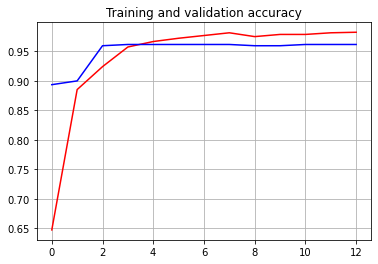

<Figure size 432x288 with 0 Axes>

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(history.epoch, acc, 'r', label='Training accuracy')
plt.plot(history.epoch, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.grid(True)
plt.figure()

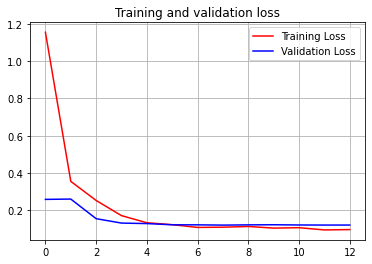

In [54]:


loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(history.epoch, loss, 'r', label='Training Loss')
plt.plot(history.epoch, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid(True)
plt.show()



In [56]:


model.evaluate(valid_generator, batch_size=1)



30/30 [==============================] - 40s 1s/step - loss: 0.1220 - accuracy: 0.9617


[0.12199116498231888, 0.9617021083831787]

In [57]:


y_pred = model.predict(valid_generator)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(valid_generator.classes, y_pred))



              precision    recall  f1-score   support

           0       0.99      0.95      0.97        97
           1       0.90      0.95      0.93        80
           2       0.97      0.99      0.98       115
           3       0.99      0.99      0.99        69
           4       0.96      0.94      0.95       109

    accuracy                           0.96       470
   macro avg       0.96      0.96      0.96       470
weighted avg       0.96      0.96      0.96       470



In [58]:
model.save("Yoga_Detection1.h5")

In [59]:
model.save("Yoga_Detectionhdf5.hdf5")

In [62]:
img = keras.preprocessing.image.load_img(
    "test5.jpg", target_size=(150,150)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
preds = np.argmax(predictions, axis=1)
score = preds[0]
print(score)
# print(
#     "This image is %.2f percent downdog and %.2f percent goddess."
#     % (100 * (1 - score), 100 * score)
# )

4
